# Filtering

This notebook investigates and catalogues the filtering steps used as part of our analysis

In [1]:
import sqlite3
import pandas as pd
from src.config import get_db_file
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
con = sqlite3.connect(get_db_file())

#### Before filtering, how many events are recorded per replicate?

In [3]:
df = pd.read_sql_query('select Alias, count(distinct outcome), sum(countEvents)\
        from outcomes_0106 group by Alias', con)
df

,Alias,count(distinct outcome),sum(countEvents)
0,MB01,514229,440291742
1,MB02,505828,434457763
2,MB03,583039,454471864
3,MB04,543906,525976002
4,MB05,584632,448212375
5,MB06,603964,421676673


There are simply too many events to work with. We will first apply a very simple filter to clear out some noise.

In [4]:
df = pd.read_sql_query('select Alias, count(distinct Barcode), count(distinct Gene)\
        from outcomes_0106 group by Alias', con)
df

,Alias,count(distinct Barcode),count(distinct Gene)
0,MB01,89414,18406
1,MB02,89423,18405
2,MB03,89492,18406
3,MB04,89481,18406
4,MB05,89477,18406
5,MB06,89478,18406


In [7]:
df = pd.read_sql_query('select Alias, Barcode, sum(countEvents) \
        from outcomes_0106 group by Alias, Barcode', con)
df.shape

(536765, 3)

In [9]:
df.head()

,Alias,Barcode,sum(countEvents),log10countEvents
0,MB01,0610009B22Rik-1,5630,3.750508
1,MB01,0610009B22Rik-2,6693,3.825621
2,MB01,0610009B22Rik-3,8660,3.937518
3,MB01,0610009B22Rik-4,8186,3.913072
4,MB01,0610009B22Rik-5,6778,3.831102


<AxesSubplot:xlabel='log10countEvents', ylabel='Alias'>

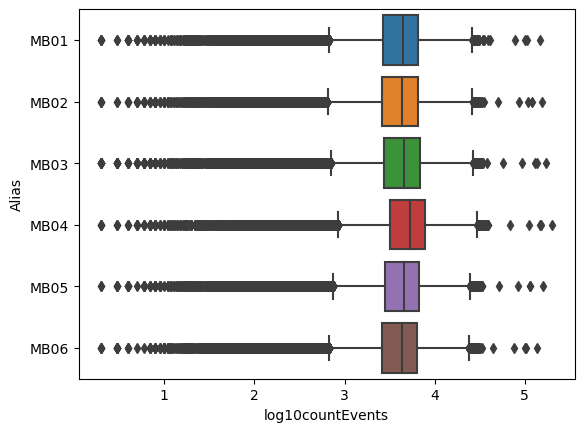

In [12]:
df["log10countEvents"] = np.log10(df["sum(countEvents)"])
sns.boxplot(data=df, x="log10countEvents", y="Alias")

In [5]:
df = pd.read_sql_query('select Alias, outcome, sum(countEvents) \
        from outcomes_0106 group by Alias, outcome', con)
df.shape

(3335598, 3)

In [6]:
df["log10countEvents"] = np.log10(df["sum(countEvents)"])

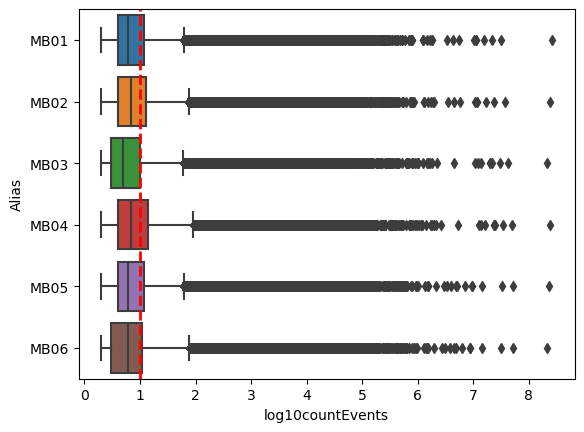

In [16]:
sns.boxplot(data=df, x="log10countEvents", y="Alias")
plt.axvline(1, lw=2, ls="--", c="r")

In [54]:
rare_df = df[df["sum(countEvents)"]<10]

In [56]:
rare_df_dets = rare_df["outcome"].str.split("|", expand=True).rename(columns={0: "Type", 1: "delRelativeStart", 2: "delRelativeEnd", 3: "misc"})
rare_df = rare_df.join(rare_df_dets)
rare_df.head()

,Alias,outcome,sum(countEvents),Type,delRelativeStart,delRelativeEnd,misc,4
12,MB01,DELETION|-10|113||0bp,8,DELETION,-10,113,,0bp
27,MB01,DELETION|-10|136||0bp,9,DELETION,-10,136,,0bp
36,MB01,DELETION|-10|148||0bp,9,DELETION,-10,148,,0bp
41,MB01,DELETION|-10|156||0bp,8,DELETION,-10,156,,0bp
65,MB01,DELETION|-10|192||0bp,9,DELETION,-10,192,,0bp


/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 800x500 with 0 Axes>

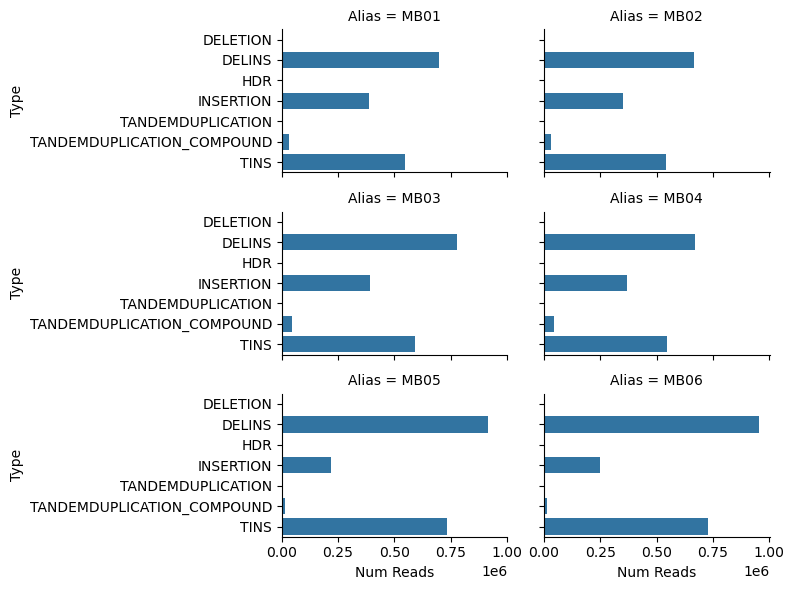

   Alias                        Type  sum(countEvents)
0   MB01                    DELETION              5170
1   MB01                      DELINS            698185
2   MB01                         HDR               305
3   MB01                   INSERTION            386801
4   MB01           TANDEMDUPLICATION                88
5   MB01  TANDEMDUPLICATION_COMPOUND             31368
6   MB01                        TINS            548433
7   MB02                    DELETION              3517
8   MB02                      DELINS            667066
9   MB02                         HDR               217
10  MB02                   INSERTION            352163
11  MB02           TANDEMDUPLICATION                98
12  MB02  TANDEMDUPLICATION_COMPOUND             29748
13  MB02                        TINS            540675
14  MB03                    DELETION              2023
15  MB03                      DELINS            776030
16  MB03                         HDR              1185
17  MB03  

In [66]:
# TODO: group by alias and get type counts
plt.figure(figsize=(8, 5))
rare_barplot_df = rare_df[["Alias", "Type", "sum(countEvents)"]].groupby(["Alias", "Type"]).sum().reset_index()
g = sns.FacetGrid(rare_barplot_df, col="Alias", col_wrap=2, size=2, aspect=2)
g.map_dataframe(sns.barplot, y="Type", x="sum(countEvents)")
g.set_xlabels("Num Reads")
plt.show()
print(rare_barplot_df)

In [20]:
rare_delins = rare_df[rare_df["Type"] == "DELINS"]
rare_delins["delLength"] = rare_delins["delRelativeEnd"].astype(int) - rare_delins["delRelativeStart"].astype(int)
rare_delins["insLength"] = rare_delins["misc"].apply(lambda x: len(x))
rare_delins.head()

/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_76757/1072920265.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rare_delins["delLength"] = rare_delins["delRelativeEnd"].astype(int) - rare_delins["delRelativeStart"].astype(int)
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_76757/1072920265.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rare_delins["insLength"] = rare_delins["misc"].apply(lambda x: len(x))


,Alias,outcome,sum(countEvents),log10countEvents,Type,delRelativeStart,delRelativeEnd,misc,4,delLength,insLength
8258,MB01,DELINS|-10|-1|AAAAAAAAA|-1bp,2,0.301030,DELINS,-10,-1,AAAAAAAAA,-1bp,9,9
8259,MB01,DELINS|-10|-1|AAAAAAAA|-1bp,9,0.954243,DELINS,-10,-1,AAAAAAAA,-1bp,9,8
8261,MB01,DELINS|-10|-1|AAAAAA|-1bp,5,0.698970,DELINS,-10,-1,AAAAAA,-1bp,9,6
8263,MB01,DELINS|-10|-1|AAAACAAAAAGGAAAACAAAA|-1bp,4,0.602060,DELINS,-10,-1,AAAACAAAAAGGAAAACAAAA,-1bp,9,21
8264,MB01,DELINS|-10|-1|AAAACTGAAAAAGGTGGAACATTT|-1bp,6,0.778151,DELINS,-10,-1,AAAACTGAAAAAGGTGGAACATTT,-1bp,9,24


In [ ]:
# get the number of reads per each type of event, could be that a lot of deletion events and getting grouped together and DELIN and TANDEMDUP events are being counted seperately
sns.countplot(rare_delins["sum(countEvents)"])


In [ ]:
sns.scatterplot(data = rare_delins, y="insLength", x="delLength", alpha=0.1)

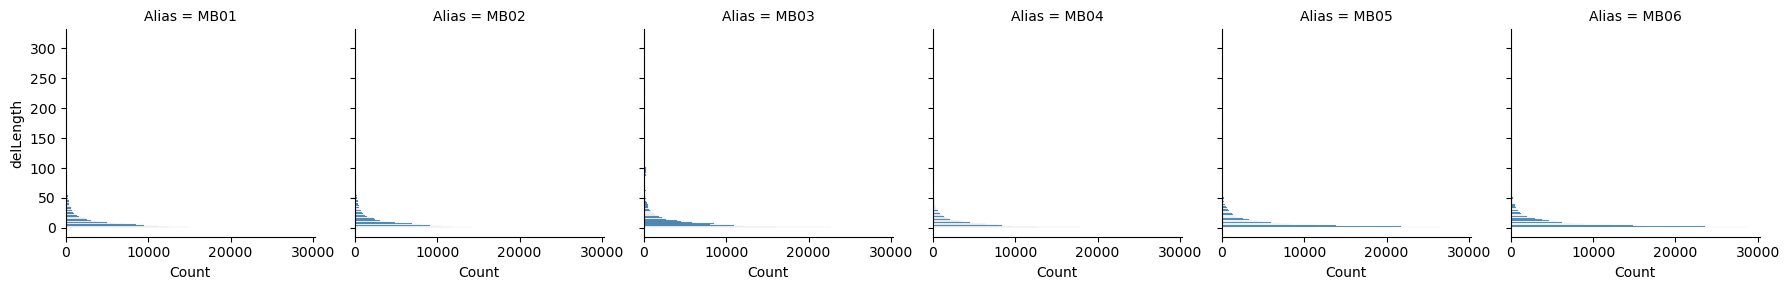

In [21]:
g = sns.FacetGrid(rare_delins, col="Alias")
g.map_dataframe(sns.histplot, y="delLength")

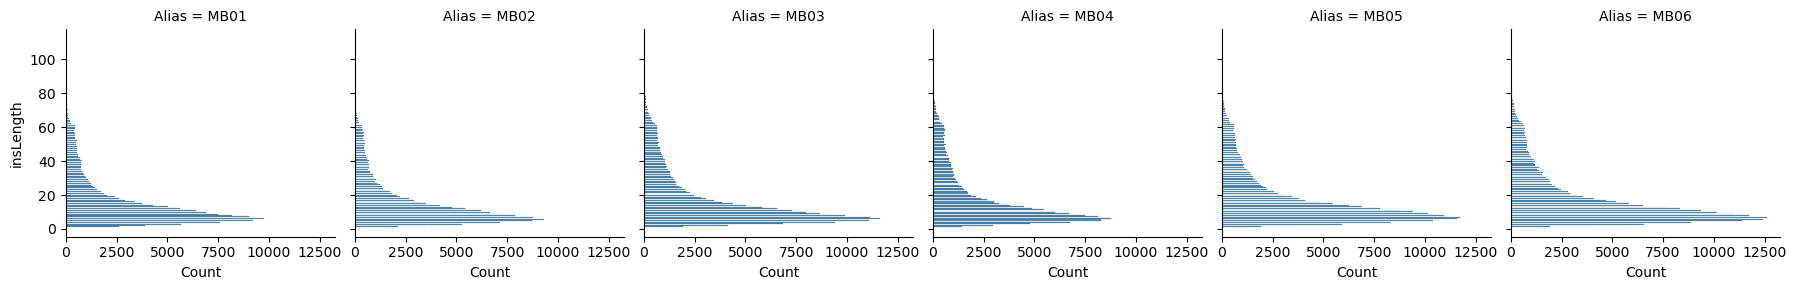

In [22]:
g = sns.FacetGrid(rare_delins, col="Alias")
g.map_dataframe(sns.histplot, y="insLength")

In [33]:
rare_df = pd.read_sql_query('select Alias, Barcode, outcome, fraction_per_barcode, countEvents \
        from outcomes_0106 where countEvents < 10', con)

In [61]:
rare_df.shape

(2270716, 8)

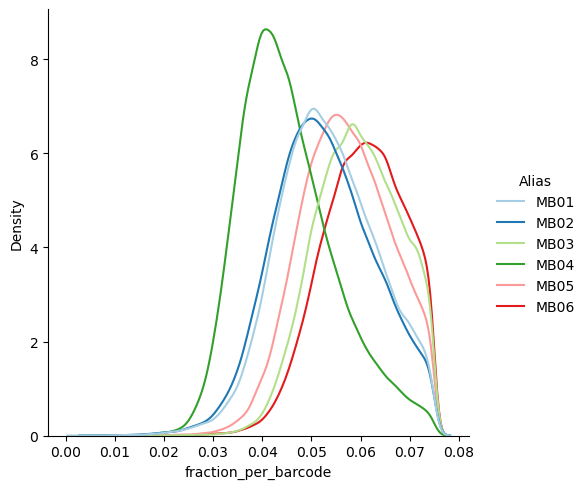

In [35]:
summed_rare_df = rare_df[["Alias", "Barcode", "fraction_per_barcode"]].groupby(["Alias", "Barcode"]).sum()

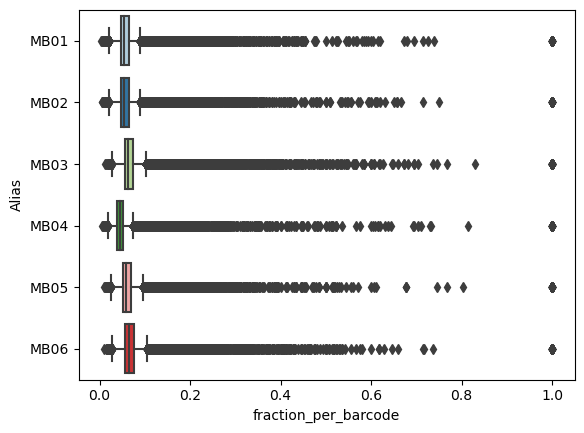

In [52]:
sns.boxplot(data=summed_rare_df.reset_index(), x="fraction_per_barcode", y="Alias", palette="Paired")
plt.show()

In [6]:
rare_df.set_index(["Alias", "Barcode", "outcome"]).head()

fraction_per_barcode
Alias Barcode         outcome                                   
MB01  0610009B22Rik-1 DELETION|-10|0||0bp               0.001243
                      DELETION|-10|19||1bp              0.000355
                      DELETION|-12|6||0bp               0.001243
                      DELETION|-13|17||3bp              0.001599
                      DELETION|-15|24||1bp              0.001599

In [67]:
rare_df = pd.read_sql_query('select Alias, Barcode, outcome, fraction_per_barcode, countEvents \
        from outcomes_0106 where countEvents < 10 and outcome like "%DELINS%"', con)

In [68]:
rare_df_dets = rare_df["outcome"].str.split("|", expand=True).rename(columns={0: "Type", 1: "delRelativeStart", 2: "delRelativeEnd", 3: "misc"})
rare_df = rare_df.join(rare_df_dets)
rare_df.head()

,Alias,Barcode,outcome,fraction_per_barcode,countEvents,Type,delRelativeStart,delRelativeEnd,misc,4
0,MB01,0610009B22Rik-1,DELINS|-11|6|A|-1bp,0.000533,3,DELINS,-11,6,A,-1bp
1,MB01,0610009B22Rik-1,DELINS|-15|4|AA|-1bp,0.000533,3,DELINS,-15,4,AA,-1bp
2,MB01,0610009B22Rik-1,DELINS|-17|1|GCGGGCAATAGGTCCAAG|-1bp,0.000533,3,DELINS,-17,1,GCGGGCAATAGGTCCAAG,-1bp
3,MB01,0610009B22Rik-1,DELINS|-17|44|G|-1bp,0.001066,6,DELINS,-17,44,G,-1bp
4,MB01,0610009B22Rik-1,DELINS|-1|1|TCCAAG|-1bp,0.000355,2,DELINS,-1,1,TCCAAG,-1bp


In [70]:
rare_df["delLength"] = rare_df["delRelativeEnd"].astype(int) - rare_df["delRelativeStart"].astype(int)
rare_df["insLength"] = rare_df["misc"].apply(lambda x: len(x))
rare_df.head()

,Alias,Barcode,outcome,fraction_per_barcode,countEvents,Type,delRelativeStart,delRelativeEnd,misc,4,delLength,insLength
0,MB01,0610009B22Rik-1,DELINS|-11|6|A|-1bp,0.000533,3,DELINS,-11,6,A,-1bp,17,1
1,MB01,0610009B22Rik-1,DELINS|-15|4|AA|-1bp,0.000533,3,DELINS,-15,4,AA,-1bp,19,2
2,MB01,0610009B22Rik-1,DELINS|-17|1|GCGGGCAATAGGTCCAAG|-1bp,0.000533,3,DELINS,-17,1,GCGGGCAATAGGTCCAAG,-1bp,18,18
3,MB01,0610009B22Rik-1,DELINS|-17|44|G|-1bp,0.001066,6,DELINS,-17,44,G,-1bp,61,1
4,MB01,0610009B22Rik-1,DELINS|-1|1|TCCAAG|-1bp,0.000355,2,DELINS,-1,1,TCCAAG,-1bp,2,6


In [92]:
rare_df["delRelativeStart"] = rare_df["delRelativeStart"].astype(int)
mean_rare_fd = rare_df.groupby(["Alias", "Barcode"]).mean().reset_index()


/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


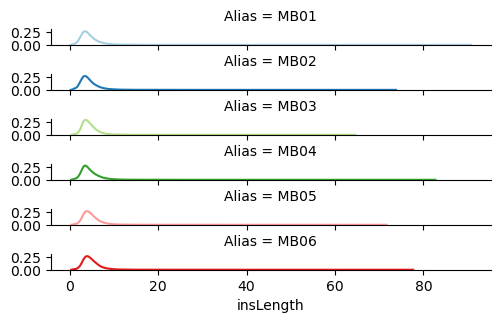

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


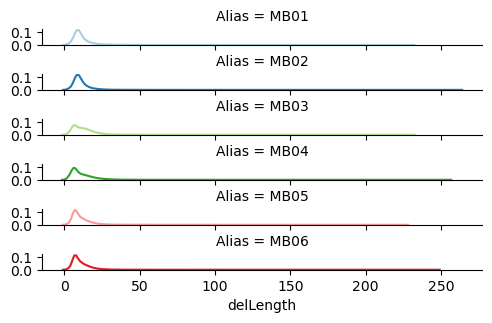

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


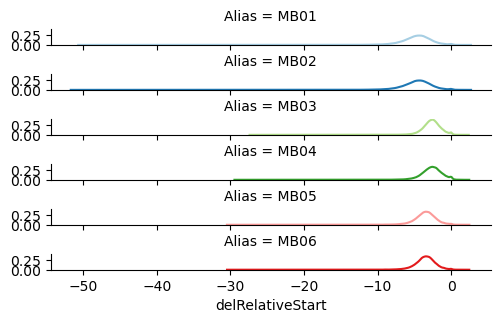

In [94]:
g = sns.FacetGrid(mean_rare_fd, row="Alias", aspect=10, height=.5, palette="Paired", hue="Alias")
g.map_dataframe(sns.kdeplot, x="insLength")
g.set_ylabels("")
plt.show()

g = sns.FacetGrid(mean_rare_fd, row="Alias", aspect=10, height=.5, palette="Paired", hue="Alias")
g.map_dataframe(sns.kdeplot, x="delLength")
g.set_ylabels("")
plt.show()

g = sns.FacetGrid(mean_rare_fd, row="Alias", aspect=10, height=.5, palette="Paired", hue="Alias")
g.map_dataframe(sns.kdeplot, x="delRelativeStart")
g.set_ylabels("")
plt.show()

In [9]:
summed_delins = rare_df[["Alias", "Barcode", "fraction_per_barcode"]].groupby(["Alias", "Barcode"]).sum()

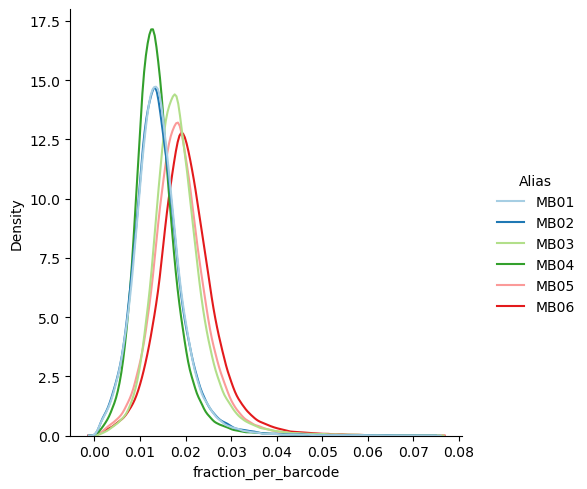

In [23]:
# summed_delins.head()

sns.displot(data=summed_delins[summed_delins["fraction_per_barcode"] < .075], x="fraction_per_barcode", kind="kde", hue="Alias", palette="Paired")
plt.show()

In [28]:
df = pd.read_sql_query('select Alias, Barcode, outcome, countEvents, fraction_per_barcode \
        from outcomes_0106 where outcome like "%DELINS%"', con)
df

,Alias,Barcode,outcome,countEvents,fraction_per_barcode
0,MB01,0610009B22Rik-1,DELINS|-11|6|A|-1bp,3,0.000533
1,MB01,0610009B22Rik-1,DELINS|-15|4|AA|-1bp,3,0.000533
2,MB01,0610009B22Rik-1,DELINS|-17|1|GCGGGCAATAGGTCCAAG|-1bp,3,0.000533
3,MB01,0610009B22Rik-1,DELINS|-17|44|G|-1bp,6,0.001066
4,MB01,0610009B22Rik-1,DELINS|-1|1|TCCAAG|-1bp,2,0.000355
...,...,...,...,...,...
12957691,MB06,Mei4-5,DELINS|-3|1|GGATCTAC|-1bp,8,0.004244
12957692,MB06,Mei4-5,DELINS|-8|2|TGCCCTAGGTCCAAG|-1bp,2,0.001061
12957693,MB06,Mei4-5,DELINS|-9|26|ACGCC|-1bp,5,0.002653
12957694,MB06,Mei4-5,DELINS|0|1|TTGGTACTTGGACTTGGACCT|-1bp,4,0.002122


In [32]:
df.sort_values(by="countEvents", ascending=False).head()

,Alias,Barcode,outcome,countEvents,fraction_per_barcode
7966994,MB04,Trp53-4,DELINS|0|2|T|-1bp,9334,0.046460
7966348,MB04,Trp53-3,DELINS|0|2|T|-1bp,6676,0.045042
5680035,MB03,Trp53-4,DELINS|0|2|T|-1bp,6526,0.038112
7965575,MB04,Trp53-1,DELINS|0|2|T|-1bp,6021,0.039906
5679380,MB03,Trp53-3,DELINS|0|2|T|-1bp,5538,0.040313


In [ ]:
rare_df_dets = rare_df["outcome"].str.split("|", expand=True).rename(columns={0: "Type", 1: "delRelativeStart", 2: "delRelativeEnd", 3: "misc"})


In [37]:
rare_df_dets = rare_df["outcome"].str.split("|", expand=True).rename(columns={0: "Type", 1: "delRelativeStart", 2: "delRelativeEnd", 3: "misc"})
rare_df = rare_df.join(rare_df_dets)
rare_delins = rare_df[rare_df["Type"] == "DELINS"]
rare_delins["delLength"] = rare_delins["delRelativeEnd"].astype(int) - rare_delins["delRelativeStart"].astype(int)
rare_delins["insLength"] = rare_delins["misc"].apply(lambda x: len(x))
rare_delins.head()

In [23]:
np.corrcoef(rare_delins["insLength"], rare_delins["delLength"])

array([[ 1.        , -0.16529094],
       [-0.16529094,  1.        ]])

In [34]:
import statsmodels.api as sm
X = rare_delins["delLength"].to_numpy().reshape(-1, 1)
y = rare_delins["insLength"].to_numpy().reshape(-1, 1)

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                 2.770e+04
Date:                Wed, 07 Sep 2022   Prob (F-statistic):               0.00
Time:                        16:07:54   Log-Likelihood:            -4.0830e+06
No. Observations:              986113   AIC:                         8.166e+06
Df Residuals:                  986111   BIC:                         8.166e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.4077      0.017   1065.167      0.0

In [ ]:
query_str_1 = 'select distinct Alias, outcome, sum(countEvents) \
        from outcomes_0106 where countEvents > 10 group by Alias'
df = pd.read_sql_query(query_str_1, con)
df

#### Before filtering, how many gRNAs are recorded per replicate?

In [ ]:
query_str_2 = 'select distinct Alias, Barcode\
        from outcomes_0106'

con = sqlite3.connect(get_db_file())
df = pd.read_sql_query(query_str_2, con)
df.shape

In [ ]:
df.groupby("Alias").size()

In [ ]:
df[df.groupby("Barcode")["Alias"].transform('nunique') == df["Alias"].nunique()].groupby("Alias").size()

In [ ]:
common_barcodes = df[df.groupby("Barcode")["Alias"].transform('nunique') == df["Alias"].nunique()]["Barcode"].unique()

#### Before filtering, how many genes are recorded per replicate?
#### What is the distribution of gRNAs per gene per replicate?

In [ ]:
query_str_3 = 'select distinct Alias, Gene, Barcode\
        from outcomes_0106'

con = sqlite3.connect(get_db_file())
df = pd.read_sql_query(query_str_3, con)

In [ ]:
df[["Alias", "Gene"]].drop_duplicates().groupby(["Alias"]).size()

In [ ]:
df_gene = df[["Alias", "Gene"]].drop_duplicates()
df_gene[df_gene.groupby("Gene")["Alias"].transform('nunique') == df_gene["Alias"].nunique()].groupby("Alias").size()

In [ ]:
common_genes = df_gene[df_gene.groupby("Gene")["Alias"].transform('nunique') == df_gene["Alias"].nunique()]["Gene"].unique()

#### Before filtering, how many unique outcomes do we have, per sample?

In [ ]:
query_str_3 = 'select Alias, count(distinct outcome)\
        from outcomes_0106 group by Alias'

con = sqlite3.connect(get_db_file())
df = pd.read_sql_query(query_str_3, con)
df

#### Before going further, we need to filter the data such that we have the same genes and the same barcodes across each sample

In [ ]:
# takes about 10 minutes to run

query_str_3 = 'select Alias, Gene, Barcode, outcome, fraction_per_barcode, countEvents\
        from outcomes_0106'

con = sqlite3.connect(get_db_file())
df_raw = pd.read_sql_query(query_str_3, con)

In [ ]:
df_raw = df_raw.set_index(["Alias", "Gene", "Barcode"])
df_raw.head()

In [ ]:
import seaborn as sns

g = sns.FacetGrid(df_raw.reset_index(), col="Alias")


In [ ]:
df_raw.xs(common_barcodes, level="Barcode")

#### Before filtering, how many reads are recorded per replicate?

#### Before filtering, how many outcomes are recorded per replicate?
#### What is the distribution of reads per outcome?
#### What is the distribution of outcomes per repair outcome profile?
#### What would make a suitable threshold to cut-off where each outcome has a significant number of reads, a significant presence in a repair outcome profile, and appears in a significant enough number of profiles?

#### How can we show that filtering has improved the quality of the data?

Could look at pairwise correlations among the repair profiles with lower reads ~200 and pairwise correlations above a certain number of reads.

Could plot read count vs pairwise correlation against other genes in the same set and choose cutoff